### Demo-01: can-PINN for 2D N-S Equations: Lid Driven Cavity (Re400)

   
    1. PINN for 2D N-S equations (lid driven cavity):
        1.0. Data
        1.1. Geometry & BC
        1.2. Sampling plan
        1.3. a-PINN / n-PINN / can-PINN
    2. Optimize PINN: [SGD]
    3. Visualize results



Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

In [2]:
from scipy import pi, exp

import seaborn as sns

## run on CPUs...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. PINN for 2D N-S equations (lid driven cavity)

    1. Incompressible Navier–Stokes equation for 2D fluid case: u(x, y), v(x, y), p(x, y)    , x∈[0, 1], y∈[-1, 0]
        - Continuity equation : u_x + v_y = 0
        - Momentum equation 1 : u*u_x + v*u_y = -p_x + vis*(u_xx + u_yy)
        - Momentum equation 2 : u*v_x + v*v_y = -p_y + vis*(v_xx + v_yy)
        
    2. BC:
        - Top    : u = 1 , v = 0 , p_n = 0
        - Left   : u = 0 , v = 0 , p_n = 0
        - Right  : u = 0 , v = 0 , p_n = 0
        - Bottom : u = 0 , v = 0 , p_n = 0
         
    3. Constants, coefficients:
        - density = 1, therefore not appear in momentum equations
        - vis: kinematic viscosity (1 / Re)

#### 1.0. Data

In [3]:
# PDE
Re = 400

# grid size
n = 51

In [4]:
# collect all .csv files from data folder
datadir = os.path.join(os.getcwd(), "d00_data")

sim = pd.read_csv(os.path.join(datadir, 'RE%d_LDC_GROUND_TRUTH_%dX%d.csv'%(Re, n, n)))
sim['x'], sim['y'] = sim['x'], sim['y'] - 1

#### 1.1. Geometry & BC

In [5]:
# spatial-temporal domain
#T = 1.0   #2

# computational boundary
x_l, x_u, y_l, y_u = 0, 1, -1, 0
ext = [x_l, x_u, y_l, y_u]

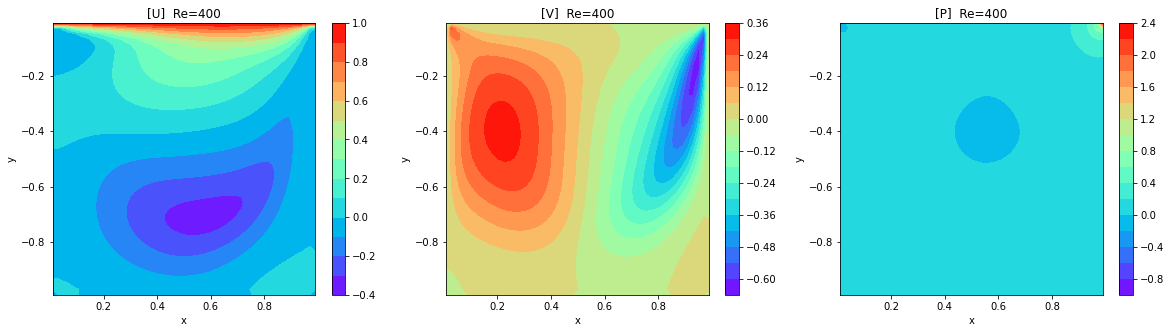

In [6]:
# visualize simulation data   
fig = plt.figure(figsize=(20, 5))
con_lv = 15
# u
ax1 = fig.add_subplot(1,3,1)
_u = sim.u.values.reshape(n, n)
plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[U]  Re=%d' %Re);

# v
ax1 = fig.add_subplot(1,3,2)
_v = sim.v.values.reshape(n, n)
plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[V]  Re=%d' %Re);
# p
ax1 = fig.add_subplot(1,3,3)
_p = sim.p.values.reshape(n, n)
plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title('[P]  Re=%d' %Re);

#### 1.2. Sampling plan

# training sample = 2601  (dx = 2.00e-02, dy = 2.00e-02)
(2601, 4) (2601, 3)


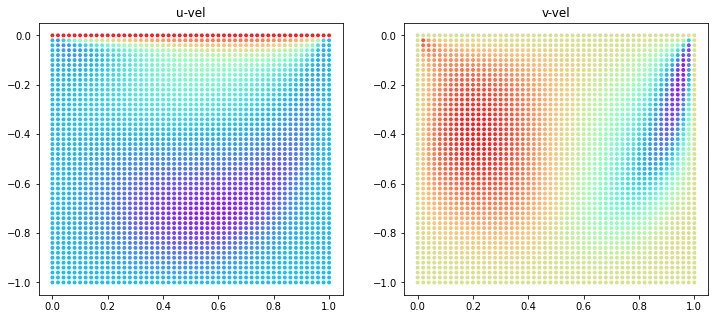

In [7]:
# dx & dy
vdx = (x_u - x_l) / (n - 1) #/ 2
vdy = (y_u - y_l) / (n - 1) #/ 2

# training sample (x * y) -> (u, v, p)
X_train = np.vstack([sim.x.values, sim.y.values, vdx * np.ones_like(sim.x.values), vdy * np.ones_like(sim.x.values)]).T
y_train = sim[['u', 'v', 'p']].values

print ('# training sample = %3d  (dx = %.2e, dy = %.2e)' %(len(y_train), vdx, vdy))
print (X_train.shape, y_train.shape)

# view
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1); _sc = 1.
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:, 0], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('u-vel');
ax1 = fig.add_subplot(1,2,2); _sc = .5
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train[:, 1], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('v-vel');

# BC sample = 200


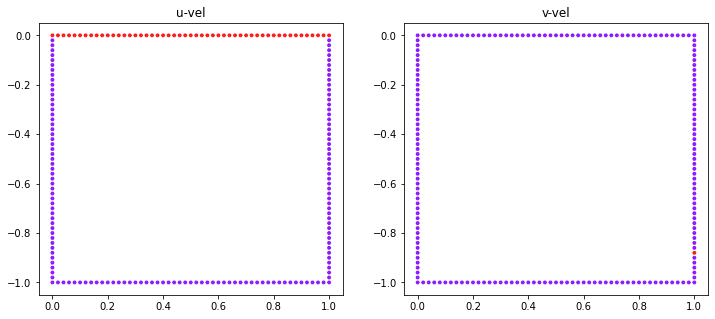

In [8]:
# BC sample
bc = np.where((X_train[:, 0] == x_u) | (X_train[:, 0] == x_l) | (X_train[:, 1] == y_u) | (X_train[:, 1] == y_l))[0]
X_bc, y_bc = X_train[bc], y_train[bc]

print ('# BC sample = %d' %len(y_bc))

# view
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1,2,1); _sc = 1.
plt.scatter(X_bc[:, 0], X_bc[:, 1], c=y_bc[:, 0], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('u-vel');
ax1 = fig.add_subplot(1,2,2); _sc = .5
plt.scatter(X_bc[:, 0], X_bc[:, 1], c=y_bc[:, 1], marker='H', s=10, alpha=.85, cmap='rainbow'); plt.title('v-vel');

In [9]:
# evaluation sample
X_eval, y_eval = X_train, y_train

# PDE sample
X_pde, y_pde = X_train, y_train

# IC sample
X_ic, y_ic = X_bc, y_bc

In [10]:
# define sampling plan
class SamplingPlan_Fix(keras.utils.Sequence):
    
    def __init__(self, data=( ), batch_size=( ), batch_per_epoch=1):
        # sampling plan: data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(n_pde, n_ic, n_bc)
        self.X, self.y, self.X_ic, self.y_ic, self.X_bc, self.y_bc = data
        self.n, self.n_ic, self.n_bc = len(self.X), len(self.X_ic), len(self.X_bc)
        self.ID, self.ID_ic, self.ID_bc = np.arange(self.n), np.arange(self.n_ic), np.arange(self.n_bc)
        # input parameters
        self.batch_size, self.batch_ic, self.batch_bc = batch_size
        self.batch_per_epoch = batch_per_epoch
        
    def __len__(self):
        # number of mini batch per epoch
        return self.batch_per_epoch
    
    def __getitem__(self, idx):
        # shuffle & pick collocation sample
        np.random.shuffle(self.ID)
        idxs = self.ID[:self.batch_size]
        batch_X, batch_y = self.X[idxs], self.y[idxs]
        # shuffle & pick ic sample
        np.random.shuffle(self.ID_ic)
        idxs = self.ID_ic[:self.batch_ic]
        batch_X_ic, batch_y_ic = self.X_ic[idxs], self.y_ic[idxs]            
        # shuffle & pick bc sample 
        np.random.shuffle(self.ID_bc)
        idxs = self.ID_bc[:self.batch_bc]
        batch_X_bc, batch_y_bc = self.X_bc[idxs], self.y_bc[idxs]
        # combine all sample
        batch_X, batch_y = np.vstack([batch_X, batch_X_ic, batch_X_bc]), np.vstack([batch_y, batch_y_ic, batch_y_bc])        
        return (batch_X, batch_y)

#### 1.3. a-PINN / n-PINN / can-PINN

In [11]:
# specify a-PINN / n-PINN / can-PINN
def create_nn(scheme, ff, n_ffs, sigma, lmbda, n_nodes, acf, lr_int):
    # input layers -> split into (x, y, dx, dy)
    inputs = layers.Input(shape=(4,))
    x, y, dx, dy = layers.Lambda( lambda k: tf.split(k, num_or_size_splits=4, axis=1))(inputs)

    # features mapping
    initializer_ff = tf.keras.initializers.TruncatedNormal(stddev=sigma)  # features initializer
    
    if (ff == 'FF'):
        hidden_f0 = layers.Dense(n_ffs, activation='linear', use_bias=False, kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))
        hidden_sin, hidden_cos = tf.math.sin(2*tf.constant(pi)*hidden_f0), tf.math.cos(2*tf.constant(pi)*hidden_f0)
        hidden_ff = layers.Concatenate()([hidden_sin, hidden_cos])
        
    if (ff == 'SF') or (ff == 'SIREN'):
        hidden_f0 = layers.Dense(n_ffs*2, activation='linear', kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))
        hidden_ff = tf.math.sin(2*tf.constant(pi)*hidden_f0)

    if (ff == 'HF'):
        hidden_ff = layers.Dense(n_ffs*2, activation=acf, kernel_initializer=initializer_ff)(layers.Concatenate()([x, y]))

    # hidden layers
    if (ff == 'SIREN'):
        initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_2)
    else:
        initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
        hidden_1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_ff)
        hidden_2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_1)
        hidden_l = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_2)

    # split layers - u
    if (ff == 'SIREN'):
        hidden_u1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_u2)
    else:
        hidden_u1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_u2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u1)
        hidden_ul = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_u2)

    # split layers - v
    if (ff == 'SIREN'):
        hidden_v1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_v2)
    else:
        hidden_v1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_v2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v1)
        hidden_vl = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_v2)  
        
    # split layers - p
    if (ff == 'SIREN'):
        hidden_p1 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_l)
        hidden_p2 = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_p1)
        hidden_pl = layers.Dense(n_nodes, activation=tf.math.sin, kernel_initializer=initializer)(hidden_p2)
    else:
        hidden_p1 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_l)
        hidden_p2 = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_p1)
        hidden_pl = layers.Dense(n_nodes, activation=acf, kernel_initializer=initializer)(hidden_p2)          
        
    # output layers
    u = layers.Dense(1, use_bias=False, name="U")(hidden_ul)
    v = layers.Dense(1, use_bias=False, name="V")(hidden_vl)
    p = layers.Dense(1, use_bias=False, name="P")(hidden_pl)  
    
    # initiate model
    outputs = layers.Concatenate()([u, v, p]) 
    nn = models.Model(inputs=inputs, outputs=outputs)
    
    # axillary PDE outputs
    u_x, u_y = K.gradients(u, x)[0], K.gradients(u, y)[0]
    v_x, v_y = K.gradients(v, x)[0], K.gradients(v, y)[0]
    p_x, p_y = K.gradients(p, x)[0], K.gradients(p, y)[0]
    u_xx, u_yy = K.gradients(u_x, x)[0], K.gradients(u_y, y)[0]
    v_xx, v_yy = K.gradients(v_x, x)[0], K.gradients(v_y, y)[0]    

    # initial & boundary conditions:
    # Top    : u = 1 , v = 0
    # Left   : u = 0 , v = 0
    # Right  : u = 0 , v = 0
    # Bottom : u = 0 , v = 0
    _top, _bottom = tf.equal(y, y_u), tf.equal(y, y_l)
    _left, _right = tf.equal(x, x_l), tf.equal(x, x_u)
    _bc = tf.logical_or( tf.logical_or(_top, _bottom) , tf.logical_or(_left, _right) )

    u_top, v_top = tf.boolean_mask(u, _top), tf.boolean_mask(v, _top)
    bc_top = tf.compat.v1.losses.mean_squared_error(labels=tf.ones_like(u_top), predictions=u_top) + \
             tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_top), predictions=v_top)

    u_left, v_left = tf.boolean_mask(u, _left & ~_top), tf.boolean_mask(v, _left & ~_top)
    bc_left = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_left), predictions=u_left) + \
              tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_left), predictions=v_left)

    u_right, v_right = tf.boolean_mask(u, _right & ~_top), tf.boolean_mask(v, _right & ~_top)
    bc_right = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_right), predictions=u_right) + \
               tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_right), predictions=v_right)

    u_bottom, v_bottom = tf.boolean_mask(u, _bottom), tf.boolean_mask(v, _bottom)
    bc_bottom = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(u_bottom), predictions=u_bottom) + \
                tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(v_bottom), predictions=v_bottom)
    
    bc_mse = bc_top + bc_left + bc_right + bc_bottom
    
    # PDE (NS equation)
    # Continuity equation : u_x + v_y = 0
    # Momentum equation 1 : u_t + u*u_x + v*u_y = -(1/rho)*p_x + nu*(u_xx + u_yy)
    # Momentum equation 2 : v_t + u*v_x + v*v_y = -(1/rho)*p_y + nu*(v_xx + v_yy)
    
    # auto-differentian PDE (a-pde)
    a_residuals_continuity = u_x + v_y
    a_residuals_momentum_1 = u*u_x + v*u_y + p_x - 1.0/Re*(u_xx + u_yy)
    a_residuals_momentum_2 = u*v_x + v*v_y + p_y - 1.0/Re*(v_xx + v_yy)
    
    # exclude BC points 
    a_residuals_continuity = tf.boolean_mask(a_residuals_continuity, ~_bc)
    a_residuals_momentum_1 = tf.boolean_mask(a_residuals_momentum_1, ~_bc)
    a_residuals_momentum_2 = tf.boolean_mask(a_residuals_momentum_2, ~_bc)
    
    a_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_continuity),
                                                              predictions=a_residuals_continuity)
    a_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_momentum_1),
                                                              predictions=a_residuals_momentum_1)
    a_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(a_residuals_momentum_2),
                                                              predictions=a_residuals_momentum_2)
    a_pde_mse = a_mse_continuity + a_mse_momentum_1 + a_mse_momentum_2
    a_pde_mse = a_pde_mse / lmbda     
    
    
    # numerical differentiation PDE (n-pde)
    # dx & dy get from input
    xE, xW = x + dx, x - dx
    yN, yS = y + dy, y - dy
    uvpE  = nn(tf.stack([xE, y, dx, dy], 1))
    uvpW  = nn(tf.stack([xW, y, dx, dy], 1))
    uvpN  = nn(tf.stack([x, yN, dx, dy], 1))
    uvpS  = nn(tf.stack([x, yS, dx, dy], 1))
    uE, vE, pE  = tf.split(uvpE, num_or_size_splits=3, axis=1)
    uW, vW, pW  = tf.split(uvpW, num_or_size_splits=3, axis=1)
    uN, vN, pN  = tf.split(uvpN, num_or_size_splits=3, axis=1)
    uS, vS, pS  = tf.split(uvpS, num_or_size_splits=3, axis=1)
    
    # second order
    xEE, xWW = x + 2.0*dx, x - 2.0*dx
    yNN, ySS = y + 2.0*dy, y - 2.0*dy    
    uvpEE = nn(tf.stack([xEE, y, dx, dy], 1))
    uvpWW = nn(tf.stack([xWW, y, dx, dy], 1))
    uvpNN = nn(tf.stack([x, yNN, dx, dy], 1))
    uvpSS = nn(tf.stack([x, ySS, dx, dy], 1))  
    uEE, vEE, _ = tf.split(uvpEE, num_or_size_splits=3, axis=1)
    uWW, vWW, _ = tf.split(uvpWW, num_or_size_splits=3, axis=1)
    uNN, vNN, _ = tf.split(uvpNN, num_or_size_splits=3, axis=1)
    uSS, vSS, _ = tf.split(uvpSS, num_or_size_splits=3, axis=1)
    
    uc_e, uc_w = 0.5*(uE + u), 0.5*(uW + u) 
    vc_n, vc_s = 0.5*(vN + v), 0.5*(vS + v)
    div = (uc_e - uc_w) /dx + (vc_n - vc_s) /dy
    
    # 2nd upwind
    Uem_uw2 = 1.5*u  - 0.5*uW
    Uep_uw2 = 1.5*uE - 0.5*uEE  
    Uwm_uw2 = 1.5*uW - 0.5*uWW
    Uwp_uw2 = 1.5*u  - 0.5*uE
    Ue_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Uem_uw2, Uep_uw2)
    Uw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Uwm_uw2, Uwp_uw2)
        
    Unm_uw2 = 1.5*u  - 0.5*uS
    Unp_uw2 = 1.5*uN - 0.5*uNN    
    Usm_uw2 = 1.5*uS - 0.5*uSS
    Usp_uw2 = 1.5*u  - 0.5*uN
    Un_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Unm_uw2, Unp_uw2)
    Us_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Usm_uw2, Usp_uw2)

    Vem_uw2 = 1.5*v  - 0.5*vW
    Vep_uw2 = 1.5*vE - 0.5*vEE
    Vwm_uw2 = 1.5*vW - 0.5*vWW
    Vwp_uw2 = 1.5*v  - 0.5*vE
    Ve_uw2 = tf.where(tf.greater_equal(uc_e, 0.0), Vem_uw2, Vep_uw2)
    Vw_uw2 = tf.where(tf.greater_equal(uc_w, 0.0), Vwm_uw2, Vwp_uw2)
        
    Vnm_uw2 = 1.5*v  - 0.5*vS
    Vnp_uw2 = 1.5*vN - 0.5*vNN    
    Vsm_uw2 = 1.5*vS - 0.5*vSS
    Vsp_uw2 = 1.5*v  - 0.5*vN
    Vn_uw2 = tf.where(tf.greater_equal(vc_n, 0.0), Vnm_uw2, Vnp_uw2)
    Vs_uw2 = tf.where(tf.greater_equal(vc_s, 0.0), Vsm_uw2, Vsp_uw2)
        
    UUx_uw2 = (uc_e*Ue_uw2 - uc_w*Uw_uw2) /dx
    VUy_uw2 = (vc_n*Un_uw2 - vc_s*Us_uw2) /dy
    UVx_uw2 = (uc_e*Ve_uw2 - uc_w*Vw_uw2) /dx
    VVy_uw2 = (vc_n*Vn_uw2 - vc_s*Vs_uw2) /dy
    
    # 2nd central difference    
    Uxx_cd2 = (uE - 2.0*u + uW)/ (dx*dx) 
    Uyy_cd2 = (uN - 2.0*u + uS)/ (dy*dy) 
    Vxx_cd2 = (vE - 2.0*v + vW)/ (dx*dx) 
    Vyy_cd2 = (vN - 2.0*v + vS)/ (dy*dy) 

    pe_cd2 = (p + pE) /2.0 
    pw_cd2 = (pW + p) /2.0 
    pn_cd2 = (p + pN) /2.0 
    ps_cd2 = (pS + p) /2.0 
    
    Px_cd2 = (pe_cd2 - pw_cd2) /dx
    Py_cd2 = (pn_cd2 - ps_cd2) /dy
        
    n_residuals_continuity = div
    n_residuals_momentum_1 = UUx_uw2 + VUy_uw2 - 1.0/Re *(Uxx_cd2 + Uyy_cd2) - u*div + Px_cd2
    n_residuals_momentum_2 = UVx_uw2 + VVy_uw2 - 1.0/Re *(Vxx_cd2 + Vyy_cd2) - v*div + Py_cd2   
    
    # exclude BC points 
    n_residuals_continuity = tf.boolean_mask(n_residuals_continuity, ~_bc)
    n_residuals_momentum_1 = tf.boolean_mask(n_residuals_momentum_1, ~_bc)
    n_residuals_momentum_2 = tf.boolean_mask(n_residuals_momentum_2, ~_bc)
    
    n_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_continuity),
                                                              predictions=n_residuals_continuity)
    n_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_momentum_1),
                                                              predictions=n_residuals_momentum_1)
    n_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(n_residuals_momentum_2),
                                                              predictions=n_residuals_momentum_2)
    n_pde_mse = n_mse_continuity + n_mse_momentum_1 + n_mse_momentum_2
    n_pde_mse = n_pde_mse / lmbda     
    
    
    # coupled automatic-numerical differentiation PDE (can-pde)
    uE_x, uW_x = K.gradients(uE, xE)[0], K.gradients(uW, xW)[0]
    uN_y, uS_y = K.gradients(uN, yN)[0], K.gradients(uS, yS)[0]
    
    vE_x, vW_x = K.gradients(vE, xE)[0], K.gradients(vW, xW)[0]
    vN_y, vS_y = K.gradients(vN, yN)[0], K.gradients(vS, yS)[0]   
    
    pE_x, pW_x = K.gradients(pE, xE)[0], K.gradients(pW, xW)[0]
    pN_y, pS_y = K.gradients(pN, yN)[0], K.gradients(pS, yS)[0]        
    
    # can 2nd upwind
    Uem_cuw2 = u  +  u_x*dx /2.0 #+ (uE_x - u_x)*dx /8.0
    Uep_cuw2 = uE - uE_x*dx /2.0 #+ (uE_x - u_x)*dx /8.0  
    Uwm_cuw2 = uW + uW_x*dx /2.0 #+ (u_x - uW_x)*dx /8.0
    Uwp_cuw2 = u  -  u_x*dx /2.0 #+ (u_x - uW_x)*dx /8.0
    Ue_cuw2 = tf.where(tf.greater_equal(uc_e, 0.0), Uem_cuw2, Uep_cuw2)
    Uw_cuw2 = tf.where(tf.greater_equal(uc_w, 0.0), Uwm_cuw2, Uwp_cuw2)    
    
    Unm_cuw2 = u  +  u_y*dy /2.0 #+ (uN_y - u_y)*dy /8.0
    Unp_cuw2 = uN - uN_y*dy /2.0 #+ (uN_y - u_y)*dy /8.0 
    Usm_cuw2 = uS + uS_y*dy /2.0 #+ (u_y - uS_y)*dy /8.0
    Usp_cuw2 = u  -  u_y*dy /2.0 #+ (u_y - uS_y)*dy /8.0
    Un_cuw2 = tf.where(tf.greater_equal(vc_n, 0.0), Unm_cuw2, Unp_cuw2)
    Us_cuw2 = tf.where(tf.greater_equal(vc_s, 0.0), Usm_cuw2, Usp_cuw2)

    Vem_cuw2 = v  +  v_x*dx /2.0 #+ (vE_x - v_x)*dx /8.0
    Vep_cuw2 = vE - vE_x*dx /2.0 #+ (vE_x - v_x)*dx /8.0
    Vwm_cuw2 = vW + vW_x*dx /2.0 #+ (v_x - vW_x)*dx /8.0
    Vwp_cuw2 = v  -  v_x*dx /2.0 #+ (v_x - vW_x)*dx /8.0
    Ve_cuw2 = tf.where(tf.greater_equal(uc_e, 0.0), Vem_cuw2, Vep_cuw2)
    Vw_cuw2 = tf.where(tf.greater_equal(uc_w, 0.0), Vwm_cuw2, Vwp_cuw2)
        
    Vnm_cuw2 = v  +  v_y*dy /2.0 #+ (vN_y - v_y)*dy /8.0
    Vnp_cuw2 = vN - vN_y*dy /2.0 #+ (vN_y - v_y)*dy /8.0
    Vsm_cuw2 = vS + vS_y*dy /2.0 #+ (v_y - vS_y)*dy /8.0
    Vsp_cuw2 = v  -  v_y*dy /2.0 #+ (v_y - vS_y)*dy /8.0
    Vn_cuw2 = tf.where(tf.greater_equal(vc_n, 0.0), Vnm_cuw2, Vnp_cuw2)
    Vs_cuw2 = tf.where(tf.greater_equal(vc_s, 0.0), Vsm_cuw2, Vsp_cuw2)    
    
    UUx_cuw2 = (uc_e*Ue_cuw2 - uc_w*Uw_cuw2) /dx
    VUy_cuw2 = (vc_n*Un_cuw2 - vc_s*Us_cuw2) /dy
    UVx_cuw2 = (uc_e*Ve_cuw2 - uc_w*Vw_cuw2) /dx
    VVy_cuw2 = (vc_n*Vn_cuw2 - vc_s*Vs_cuw2) /dy       
    
    # can 2nd central difference    
    pe_ccd2 = (p + pE) /2.0 - (pE_x - p_x)*dx /8.0
    pw_ccd2 = (pW + p) /2.0 - (p_x - pW_x)*dx /8.0
    pn_ccd2 = (p + pN) /2.0 - (pN_y - p_y)*dy /8.0
    ps_ccd2 = (pS + p) /2.0 - (p_y - pS_y)*dy /8.0
        
    Px_ccd2 = (pe_ccd2 - pw_ccd2) /dx
    Py_ccd2 = (pn_ccd2 - ps_ccd2) /dy    
    
    can_residuals_continuity = div
    can_residuals_momentum_1 = UUx_cuw2 + VUy_cuw2 - 1.0/Re *(Uxx_cd2 + Uyy_cd2) - u*div + Px_ccd2
    can_residuals_momentum_2 = UVx_cuw2 + VVy_cuw2 - 1.0/Re *(Vxx_cd2 + Vyy_cd2) - v*div + Py_ccd2

    # exclude BC points 
    can_residuals_continuity = tf.boolean_mask(can_residuals_continuity, ~_bc)
    can_residuals_momentum_1 = tf.boolean_mask(can_residuals_momentum_1, ~_bc)
    can_residuals_momentum_2 = tf.boolean_mask(can_residuals_momentum_2, ~_bc)
    
    can_mse_continuity = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_continuity),
                                                                predictions=can_residuals_continuity)
    can_mse_momentum_1 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_momentum_1),
                                                                predictions=can_residuals_momentum_1)
    can_mse_momentum_2 = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(can_residuals_momentum_2),
                                                                predictions=can_residuals_momentum_2)
    can_pde_mse = can_mse_continuity + can_mse_momentum_1 + can_mse_momentum_2
    can_pde_mse = can_pde_mse / lmbda  
    
    
    # which method to use for PDE loss computation? a-PDE or n-PDE or can-PDE
    if (scheme == 'a-pde'):
        pde_mse = a_pde_mse
    if (scheme == 'n-pde'):
        pde_mse = n_pde_mse
    if (scheme == 'can-pde'):
        pde_mse = can_pde_mse    

        
    # optimizer
    optimizer = tf.keras.optimizers.Adam(lr_int)

    # compile model with [?] loss
    nn.compile(loss = compute_physics_loss(pde_mse, bc_mse),
               optimizer = optimizer,
               metrics = [compute_u_loss(dx), compute_v_loss(dy),
                          compute_bc_loss(bc_mse), compute_pde_loss(pde_mse)])

    # pathway to NN inside variables
    insiders = [u, v, p, pde_mse, bc_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function

    return (nn, eval_ins)


In [12]:
# loss functions
# define loss function (data loss)
def compute_data_loss():
    def data_loss(y_true, y_pred):
        return tf.compat.v1.losses.mean_squared_error(labels=y_true, predictions=y_pred)
    return data_loss

# define loss function (u loss)
def compute_u_loss(dx):
    def u_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.greater_equal(dx, 0), (1, 1)),
                            tf.tile(tf.equal(dx, -1), (1, 2))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))        
    return u_loss # return a function

# define loss function (v loss)
def compute_v_loss(dx):
    def v_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.equal(dx, -1), (1, 1)),
                            tf.tile(tf.greater_equal(dx, 0), (1, 1)),
                            tf.tile(tf.equal(dx, -1), (1, 1))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))    
    return v_loss # return a function

# define loss function (p loss)
def compute_p_loss(dx):
    def p_loss(y_true, y_pred):
        labels = tf.concat([tf.tile(tf.equal(dx, -1), (1, 2)),
                            tf.tile(tf.greater_equal(dx, 0), (1, 1))], 1)
        return tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(y_true, labels),
                                                      predictions=tf.boolean_mask(y_pred, labels))    
    return p_loss # return a function

# define loss function (physics loss)
def compute_physics_loss(pde_mse, bc_mse):
    def physics_loss(y_true, y_pred): return pde_mse + bc_mse
    return physics_loss # return a function

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function



# callback: training (prediction & residual) history
class TrainingHistory(Callback):
    def __init__(self, eval_ins, data):
        super(Callback, self).__init__()
        self.data = data
        self.eval_ins = eval_ins
        self.e_hist = []
        self.u_hist = []
        self.v_hist = []
        self.p_hist = []
        self.pde_mse_hist = []
        self.bc_mse_hist = []
    def on_epoch_end(self, epoch, logs={}):
        e = epoch + 1
        if (e < 10) | ((e < 100) & (e%10 == 0)) | ((e < 1000) & (e%100 == 0)) | (e%1000 == 0):
            data = self.data
            u, v, p, pde_mse, bc_mse = self.eval_ins(data)
            self.e_hist.append(e)
            self.u_hist.append(u)
            self.v_hist.append(v)
            self.p_hist.append(p)
            self.pde_mse_hist.append(pde_mse)
            self.bc_mse_hist.append(bc_mse)
            

### 2. Optimize D-PDE-NN: [SGD]

In [13]:
# initiate NN model (& pathway to internal values)
n_ffs = 32
lmbda = 1.0

ff = 'SIREN'
sigma = 1.0

# select scheme : 'a-pde', 'n-pde', 'can-pde' 
scheme = 'can-pde'

nn, eval_ins = create_nn(scheme, ff, n_ffs, sigma, lmbda, n_nodes = 20, acf = 'tanh', lr_int = 0.001)

# first pass
u_0, v_0, p_0, pde_mse_0, bc_mse_0 = eval_ins(X_eval) 
    
nn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 [(None, 1), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2)            0           lambda[0][0]                     
                                                                 lambda[0][1]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           192         concatenate[0][0]     

In [14]:
# PINN training setting: EPOCH, learning rate & sampling strategy
EPOCH = 2000
BPE = 100
LR = 1e-3
DGEN = SamplingPlan_Fix(data=(X_pde, y_pde, X_ic, y_ic, X_bc, y_bc), batch_size=(475, 0, 25), batch_per_epoch=BPE)

# callback setting: learning rate schedule & training history
lr_sched = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=5e-6)
tr_hist = TrainingHistory(eval_ins, X_eval)
callbacks_list = [lr_sched, tr_hist]

# time it
t0 = time()

# train NN model
K.set_value(nn.optimizer.lr, LR)  # set learning rate
history = nn.fit(DGEN, epochs=EPOCH, verbose=2, callbacks=callbacks_list)

print ("...\nRunning time: %d mins %d secs!" %(int(time()-t0)/60, np.remainder(int(time()-t0), 60)))

Epoch 1/2000
100/100 - 1s - loss: 47.4941 - u_loss: 0.1666 - v_loss: 0.1151 - bc_loss: 1.7866 - pde_loss: 45.7074
Epoch 2/2000
100/100 - 1s - loss: 2.9155 - u_loss: 0.0469 - v_loss: 0.0357 - bc_loss: 0.6361 - pde_loss: 2.2794
Epoch 3/2000
100/100 - 1s - loss: 1.4344 - u_loss: 0.0347 - v_loss: 0.0327 - bc_loss: 0.3927 - pde_loss: 1.0418
Epoch 4/2000
100/100 - 1s - loss: 0.9258 - u_loss: 0.0306 - v_loss: 0.0321 - bc_loss: 0.2802 - pde_loss: 0.6456
Epoch 5/2000
100/100 - 1s - loss: 0.6647 - u_loss: 0.0285 - v_loss: 0.0331 - bc_loss: 0.2089 - pde_loss: 0.4558
Epoch 6/2000
100/100 - 1s - loss: 0.5119 - u_loss: 0.0276 - v_loss: 0.0325 - bc_loss: 0.1701 - pde_loss: 0.3418
Epoch 7/2000
100/100 - 1s - loss: 0.4154 - u_loss: 0.0271 - v_loss: 0.0322 - bc_loss: 0.1410 - pde_loss: 0.2743
Epoch 8/2000
100/100 - 1s - loss: 0.3342 - u_loss: 0.0265 - v_loss: 0.0312 - bc_loss: 0.1155 - pde_loss: 0.2187
Epoch 9/2000
100/100 - 1s - loss: 0.2829 - u_loss: 0.0264 - v_loss: 0.0309 - bc_loss: 0.1005 - pde_los

Epoch 74/2000
100/100 - 1s - loss: 0.0148 - u_loss: 0.0263 - v_loss: 0.0308 - bc_loss: 0.0077 - pde_loss: 0.0070
Epoch 75/2000
100/100 - 1s - loss: 0.0135 - u_loss: 0.0264 - v_loss: 0.0315 - bc_loss: 0.0075 - pde_loss: 0.0060
Epoch 76/2000
100/100 - 1s - loss: 0.0112 - u_loss: 0.0261 - v_loss: 0.0311 - bc_loss: 0.0062 - pde_loss: 0.0050
Epoch 77/2000
100/100 - 1s - loss: 0.0129 - u_loss: 0.0266 - v_loss: 0.0314 - bc_loss: 0.0074 - pde_loss: 0.0055
Epoch 78/2000
100/100 - 1s - loss: 0.0138 - u_loss: 0.0268 - v_loss: 0.0311 - bc_loss: 0.0077 - pde_loss: 0.0061
Epoch 79/2000
100/100 - 1s - loss: 0.0131 - u_loss: 0.0263 - v_loss: 0.0317 - bc_loss: 0.0073 - pde_loss: 0.0058
Epoch 80/2000
100/100 - 1s - loss: 0.0115 - u_loss: 0.0266 - v_loss: 0.0316 - bc_loss: 0.0061 - pde_loss: 0.0055
Epoch 81/2000
100/100 - 1s - loss: 0.0151 - u_loss: 0.0269 - v_loss: 0.0317 - bc_loss: 0.0076 - pde_loss: 0.0075
Epoch 82/2000
100/100 - 1s - loss: 0.0130 - u_loss: 0.0266 - v_loss: 0.0315 - bc_loss: 0.0068 - 

100/100 - 1s - loss: 0.0037 - u_loss: 0.0233 - v_loss: 0.0237 - bc_loss: 0.0015 - pde_loss: 0.0023
Epoch 147/2000
100/100 - 1s - loss: 0.0041 - u_loss: 0.0232 - v_loss: 0.0236 - bc_loss: 0.0014 - pde_loss: 0.0026
Epoch 148/2000
100/100 - 1s - loss: 0.0043 - u_loss: 0.0231 - v_loss: 0.0234 - bc_loss: 0.0015 - pde_loss: 0.0028
Epoch 149/2000
100/100 - 1s - loss: 0.0034 - u_loss: 0.0232 - v_loss: 0.0232 - bc_loss: 0.0013 - pde_loss: 0.0021
Epoch 150/2000
100/100 - 1s - loss: 0.0035 - u_loss: 0.0231 - v_loss: 0.0231 - bc_loss: 0.0013 - pde_loss: 0.0023
Epoch 151/2000
100/100 - 1s - loss: 0.0038 - u_loss: 0.0228 - v_loss: 0.0230 - bc_loss: 0.0012 - pde_loss: 0.0026
Epoch 152/2000
100/100 - 1s - loss: 0.0039 - u_loss: 0.0226 - v_loss: 0.0231 - bc_loss: 0.0013 - pde_loss: 0.0026
Epoch 153/2000
100/100 - 1s - loss: 0.0052 - u_loss: 0.0226 - v_loss: 0.0229 - bc_loss: 0.0015 - pde_loss: 0.0037
Epoch 154/2000
100/100 - 1s - loss: 0.0042 - u_loss: 0.0225 - v_loss: 0.0227 - bc_loss: 0.0013 - pde_lo

Epoch 217/2000
100/100 - 1s - loss: 0.0026 - u_loss: 0.0165 - v_loss: 0.0154 - bc_loss: 7.7755e-04 - pde_loss: 0.0018
Epoch 218/2000
100/100 - 1s - loss: 0.0027 - u_loss: 0.0163 - v_loss: 0.0156 - bc_loss: 6.6590e-04 - pde_loss: 0.0020
Epoch 219/2000
100/100 - 1s - loss: 0.0017 - u_loss: 0.0162 - v_loss: 0.0152 - bc_loss: 4.6529e-04 - pde_loss: 0.0012
Epoch 220/2000
100/100 - 1s - loss: 0.0019 - u_loss: 0.0163 - v_loss: 0.0153 - bc_loss: 4.9010e-04 - pde_loss: 0.0014
Epoch 221/2000
100/100 - 1s - loss: 0.0036 - u_loss: 0.0160 - v_loss: 0.0155 - bc_loss: 7.9638e-04 - pde_loss: 0.0028
Epoch 222/2000
100/100 - 1s - loss: 0.0018 - u_loss: 0.0160 - v_loss: 0.0153 - bc_loss: 5.1960e-04 - pde_loss: 0.0013
Epoch 223/2000
100/100 - 1s - loss: 0.0029 - u_loss: 0.0162 - v_loss: 0.0153 - bc_loss: 7.4672e-04 - pde_loss: 0.0021
Epoch 224/2000
100/100 - 1s - loss: 0.0034 - u_loss: 0.0157 - v_loss: 0.0155 - bc_loss: 8.4352e-04 - pde_loss: 0.0025
Epoch 225/2000
100/100 - 1s - loss: 0.0015 - u_loss: 0.0

Epoch 287/2000
100/100 - 1s - loss: 0.0013 - u_loss: 0.0113 - v_loss: 0.0103 - bc_loss: 3.6429e-04 - pde_loss: 9.8458e-04
Epoch 288/2000
100/100 - 1s - loss: 0.0014 - u_loss: 0.0112 - v_loss: 0.0104 - bc_loss: 3.4568e-04 - pde_loss: 0.0011
Epoch 289/2000
100/100 - 1s - loss: 0.0018 - u_loss: 0.0111 - v_loss: 0.0104 - bc_loss: 5.0774e-04 - pde_loss: 0.0013
Epoch 290/2000
100/100 - 1s - loss: 0.0026 - u_loss: 0.0110 - v_loss: 0.0106 - bc_loss: 6.5767e-04 - pde_loss: 0.0019
Epoch 291/2000
100/100 - 1s - loss: 0.0017 - u_loss: 0.0110 - v_loss: 0.0106 - bc_loss: 5.1172e-04 - pde_loss: 0.0012
Epoch 292/2000
100/100 - 1s - loss: 0.0012 - u_loss: 0.0109 - v_loss: 0.0101 - bc_loss: 3.4450e-04 - pde_loss: 8.9193e-04
Epoch 293/2000
100/100 - 1s - loss: 0.0014 - u_loss: 0.0108 - v_loss: 0.0100 - bc_loss: 4.2910e-04 - pde_loss: 0.0010
Epoch 294/2000
100/100 - 1s - loss: 0.0031 - u_loss: 0.0107 - v_loss: 0.0104 - bc_loss: 6.0362e-04 - pde_loss: 0.0025
Epoch 295/2000
100/100 - 1s - loss: 0.0014 - u_l

Epoch 355/2000
100/100 - 1s - loss: 0.0011 - u_loss: 0.0077 - v_loss: 0.0075 - bc_loss: 2.7801e-04 - pde_loss: 7.9075e-04
Epoch 356/2000
100/100 - 1s - loss: 9.3780e-04 - u_loss: 0.0076 - v_loss: 0.0073 - bc_loss: 2.4162e-04 - pde_loss: 6.9618e-04
Epoch 357/2000
100/100 - 1s - loss: 0.0053 - u_loss: 0.0080 - v_loss: 0.0083 - bc_loss: 0.0014 - pde_loss: 0.0038
Epoch 358/2000
100/100 - 1s - loss: 0.0012 - u_loss: 0.0080 - v_loss: 0.0081 - bc_loss: 4.0213e-04 - pde_loss: 8.0633e-04
Epoch 359/2000
100/100 - 1s - loss: 0.0034 - u_loss: 0.0077 - v_loss: 0.0079 - bc_loss: 7.6474e-04 - pde_loss: 0.0027
Epoch 360/2000
100/100 - 1s - loss: 0.0032 - u_loss: 0.0082 - v_loss: 0.0086 - bc_loss: 8.6621e-04 - pde_loss: 0.0023
Epoch 361/2000
100/100 - 1s - loss: 7.1774e-04 - u_loss: 0.0076 - v_loss: 0.0076 - bc_loss: 2.2492e-04 - pde_loss: 4.9282e-04
Epoch 362/2000
100/100 - 1s - loss: 9.5811e-04 - u_loss: 0.0076 - v_loss: 0.0073 - bc_loss: 2.6631e-04 - pde_loss: 6.9180e-04
Epoch 363/2000
100/100 - 1s 

100/100 - 1s - loss: 4.7579e-04 - u_loss: 0.0040 - v_loss: 0.0036 - bc_loss: 1.1415e-04 - pde_loss: 3.6164e-04
Epoch 422/2000
100/100 - 1s - loss: 1.5907e-04 - u_loss: 0.0039 - v_loss: 0.0035 - bc_loss: 5.1607e-05 - pde_loss: 1.0746e-04
Epoch 423/2000
100/100 - 1s - loss: 1.2564e-04 - u_loss: 0.0039 - v_loss: 0.0035 - bc_loss: 4.1781e-05 - pde_loss: 8.3858e-05
Epoch 424/2000
100/100 - 1s - loss: 1.2267e-04 - u_loss: 0.0038 - v_loss: 0.0034 - bc_loss: 4.1379e-05 - pde_loss: 8.1296e-05
Epoch 425/2000
100/100 - 1s - loss: 1.2886e-04 - u_loss: 0.0038 - v_loss: 0.0034 - bc_loss: 4.1850e-05 - pde_loss: 8.7005e-05
Epoch 426/2000
100/100 - 1s - loss: 1.2892e-04 - u_loss: 0.0037 - v_loss: 0.0033 - bc_loss: 4.1902e-05 - pde_loss: 8.7019e-05
Epoch 427/2000
100/100 - 1s - loss: 1.2771e-04 - u_loss: 0.0036 - v_loss: 0.0033 - bc_loss: 4.0376e-05 - pde_loss: 8.7330e-05
Epoch 428/2000
100/100 - 1s - loss: 1.3704e-04 - u_loss: 0.0036 - v_loss: 0.0032 - bc_loss: 4.2269e-05 - pde_loss: 9.4775e-05
Epoch 4

Epoch 487/2000
100/100 - 1s - loss: 8.9327e-05 - u_loss: 0.0016 - v_loss: 0.0014 - bc_loss: 2.4020e-05 - pde_loss: 6.5307e-05
Epoch 488/2000
100/100 - 1s - loss: 8.3316e-05 - u_loss: 0.0016 - v_loss: 0.0014 - bc_loss: 2.2928e-05 - pde_loss: 6.0388e-05
Epoch 489/2000
100/100 - 1s - loss: 1.1355e-04 - u_loss: 0.0016 - v_loss: 0.0014 - bc_loss: 3.0156e-05 - pde_loss: 8.3391e-05
Epoch 490/2000
100/100 - 1s - loss: 7.3475e-05 - u_loss: 0.0015 - v_loss: 0.0014 - bc_loss: 2.0442e-05 - pde_loss: 5.3033e-05
Epoch 491/2000
100/100 - 1s - loss: 7.6201e-05 - u_loss: 0.0015 - v_loss: 0.0014 - bc_loss: 1.9505e-05 - pde_loss: 5.6696e-05
Epoch 492/2000
100/100 - 1s - loss: 1.0209e-04 - u_loss: 0.0015 - v_loss: 0.0014 - bc_loss: 2.5897e-05 - pde_loss: 7.6191e-05
Epoch 493/2000
100/100 - 1s - loss: 7.5737e-05 - u_loss: 0.0015 - v_loss: 0.0013 - bc_loss: 2.1018e-05 - pde_loss: 5.4719e-05
Epoch 494/2000
100/100 - 1s - loss: 1.3625e-04 - u_loss: 0.0015 - v_loss: 0.0013 - bc_loss: 3.2253e-05 - pde_loss: 1.0

Epoch 551/2000
100/100 - 1s - loss: 9.3610e-05 - u_loss: 7.5912e-04 - v_loss: 7.2795e-04 - bc_loss: 2.1176e-05 - pde_loss: 7.2433e-05
Epoch 552/2000
100/100 - 1s - loss: 4.8552e-05 - u_loss: 7.5091e-04 - v_loss: 7.2417e-04 - bc_loss: 1.1511e-05 - pde_loss: 3.7040e-05
Epoch 553/2000
100/100 - 1s - loss: 4.3662e-05 - u_loss: 7.4775e-04 - v_loss: 7.0870e-04 - bc_loss: 1.0808e-05 - pde_loss: 3.2854e-05
Epoch 554/2000
100/100 - 1s - loss: 6.9076e-05 - u_loss: 7.3441e-04 - v_loss: 7.0762e-04 - bc_loss: 1.6154e-05 - pde_loss: 5.2922e-05
Epoch 555/2000
100/100 - 1s - loss: 7.6007e-05 - u_loss: 7.3363e-04 - v_loss: 7.0642e-04 - bc_loss: 1.8335e-05 - pde_loss: 5.7672e-05
Epoch 556/2000
100/100 - 1s - loss: 5.0814e-05 - u_loss: 7.2600e-04 - v_loss: 6.9674e-04 - bc_loss: 1.2095e-05 - pde_loss: 3.8719e-05
Epoch 557/2000
100/100 - 1s - loss: 7.4610e-05 - u_loss: 7.1254e-04 - v_loss: 6.8008e-04 - bc_loss: 1.6817e-05 - pde_loss: 5.7793e-05
Epoch 558/2000
100/100 - 1s - loss: 3.7467e-05 - u_loss: 7.102

Epoch 613/2000
100/100 - 1s - loss: 2.8065e-05 - u_loss: 4.7542e-04 - v_loss: 4.7849e-04 - bc_loss: 6.2772e-06 - pde_loss: 2.1788e-05
Epoch 614/2000
100/100 - 1s - loss: 2.7190e-05 - u_loss: 4.6955e-04 - v_loss: 4.7797e-04 - bc_loss: 6.1439e-06 - pde_loss: 2.1046e-05
Epoch 615/2000
100/100 - 1s - loss: 2.7627e-05 - u_loss: 4.7494e-04 - v_loss: 4.7403e-04 - bc_loss: 6.3427e-06 - pde_loss: 2.1284e-05
Epoch 616/2000
100/100 - 1s - loss: 2.6888e-05 - u_loss: 4.7118e-04 - v_loss: 4.6901e-04 - bc_loss: 6.1484e-06 - pde_loss: 2.0740e-05
Epoch 617/2000
100/100 - 1s - loss: 2.6805e-05 - u_loss: 4.7248e-04 - v_loss: 4.5814e-04 - bc_loss: 5.8930e-06 - pde_loss: 2.0912e-05
Epoch 618/2000
100/100 - 1s - loss: 2.7968e-05 - u_loss: 4.6764e-04 - v_loss: 4.6866e-04 - bc_loss: 6.2391e-06 - pde_loss: 2.1729e-05
Epoch 619/2000
100/100 - 1s - loss: 2.6851e-05 - u_loss: 4.7144e-04 - v_loss: 4.6282e-04 - bc_loss: 5.8304e-06 - pde_loss: 2.1021e-05
Epoch 620/2000
100/100 - 1s - loss: 2.9240e-05 - u_loss: 4.545

Epoch 675/2000
100/100 - 1s - loss: 2.2009e-05 - u_loss: 3.6456e-04 - v_loss: 3.7123e-04 - bc_loss: 4.6959e-06 - pde_loss: 1.7314e-05
Epoch 676/2000
100/100 - 1s - loss: 2.2142e-05 - u_loss: 3.6450e-04 - v_loss: 3.7735e-04 - bc_loss: 4.6815e-06 - pde_loss: 1.7460e-05
Epoch 677/2000
100/100 - 1s - loss: 2.1629e-05 - u_loss: 3.6752e-04 - v_loss: 3.6709e-04 - bc_loss: 4.3898e-06 - pde_loss: 1.7239e-05
Epoch 678/2000
100/100 - 1s - loss: 2.1953e-05 - u_loss: 3.6890e-04 - v_loss: 3.7036e-04 - bc_loss: 4.6931e-06 - pde_loss: 1.7260e-05
Epoch 679/2000
100/100 - 1s - loss: 2.1926e-05 - u_loss: 3.7175e-04 - v_loss: 3.7496e-04 - bc_loss: 4.5757e-06 - pde_loss: 1.7350e-05
Epoch 680/2000
100/100 - 1s - loss: 2.1610e-05 - u_loss: 3.6817e-04 - v_loss: 3.7215e-04 - bc_loss: 4.5128e-06 - pde_loss: 1.7097e-05
Epoch 681/2000
100/100 - 1s - loss: 2.1139e-05 - u_loss: 3.6560e-04 - v_loss: 3.6780e-04 - bc_loss: 4.3513e-06 - pde_loss: 1.6788e-05
Epoch 682/2000
100/100 - 1s - loss: 2.1393e-05 - u_loss: 3.668

Epoch 737/2000
100/100 - 1s - loss: 1.8926e-05 - u_loss: 3.1912e-04 - v_loss: 3.3389e-04 - bc_loss: 3.7989e-06 - pde_loss: 1.5127e-05
Epoch 738/2000
100/100 - 1s - loss: 1.8768e-05 - u_loss: 3.3006e-04 - v_loss: 3.3686e-04 - bc_loss: 3.7830e-06 - pde_loss: 1.4985e-05
Epoch 739/2000
100/100 - 1s - loss: 1.8674e-05 - u_loss: 3.1569e-04 - v_loss: 3.2805e-04 - bc_loss: 3.7323e-06 - pde_loss: 1.4941e-05
Epoch 740/2000
100/100 - 1s - loss: 1.8698e-05 - u_loss: 3.2526e-04 - v_loss: 3.3827e-04 - bc_loss: 3.7411e-06 - pde_loss: 1.4957e-05
Epoch 741/2000
100/100 - 1s - loss: 1.8983e-05 - u_loss: 3.1999e-04 - v_loss: 3.2847e-04 - bc_loss: 3.7558e-06 - pde_loss: 1.5227e-05
Epoch 742/2000
100/100 - 1s - loss: 1.8665e-05 - u_loss: 3.2134e-04 - v_loss: 3.2898e-04 - bc_loss: 3.7058e-06 - pde_loss: 1.4959e-05
Epoch 743/2000
100/100 - 1s - loss: 1.8590e-05 - u_loss: 3.2305e-04 - v_loss: 3.3078e-04 - bc_loss: 3.6315e-06 - pde_loss: 1.4958e-05
Epoch 744/2000
100/100 - 1s - loss: 1.8672e-05 - u_loss: 3.147

Epoch 799/2000
100/100 - 1s - loss: 1.7432e-05 - u_loss: 2.9847e-04 - v_loss: 3.1069e-04 - bc_loss: 3.4223e-06 - pde_loss: 1.4010e-05
Epoch 800/2000
100/100 - 1s - loss: 1.7255e-05 - u_loss: 2.9977e-04 - v_loss: 3.1443e-04 - bc_loss: 3.4708e-06 - pde_loss: 1.3784e-05
Epoch 801/2000
100/100 - 1s - loss: 1.7428e-05 - u_loss: 2.9824e-04 - v_loss: 3.1070e-04 - bc_loss: 3.4335e-06 - pde_loss: 1.3994e-05
Epoch 802/2000
100/100 - 1s - loss: 1.7333e-05 - u_loss: 2.9681e-04 - v_loss: 3.1254e-04 - bc_loss: 3.3668e-06 - pde_loss: 1.3966e-05
Epoch 803/2000
100/100 - 1s - loss: 1.7515e-05 - u_loss: 2.9202e-04 - v_loss: 3.0736e-04 - bc_loss: 3.3176e-06 - pde_loss: 1.4197e-05
Epoch 804/2000
100/100 - 1s - loss: 1.7143e-05 - u_loss: 2.9601e-04 - v_loss: 3.1213e-04 - bc_loss: 3.2462e-06 - pde_loss: 1.3897e-05
Epoch 805/2000
100/100 - 1s - loss: 1.7192e-05 - u_loss: 2.9872e-04 - v_loss: 3.0876e-04 - bc_loss: 3.2459e-06 - pde_loss: 1.3946e-05
Epoch 806/2000
100/100 - 1s - loss: 1.7247e-05 - u_loss: 3.058

Epoch 861/2000
100/100 - 1s - loss: 1.6768e-05 - u_loss: 2.8307e-04 - v_loss: 2.9424e-04 - bc_loss: 3.2044e-06 - pde_loss: 1.3564e-05
Epoch 862/2000
100/100 - 1s - loss: 1.6312e-05 - u_loss: 2.8021e-04 - v_loss: 2.8967e-04 - bc_loss: 3.0024e-06 - pde_loss: 1.3309e-05
Epoch 863/2000
100/100 - 1s - loss: 1.6506e-05 - u_loss: 2.8543e-04 - v_loss: 2.9509e-04 - bc_loss: 3.0707e-06 - pde_loss: 1.3435e-05
Epoch 864/2000
100/100 - 1s - loss: 1.6584e-05 - u_loss: 2.7936e-04 - v_loss: 2.9290e-04 - bc_loss: 3.1603e-06 - pde_loss: 1.3424e-05
Epoch 865/2000
100/100 - 1s - loss: 1.6414e-05 - u_loss: 2.8242e-04 - v_loss: 2.9351e-04 - bc_loss: 3.2058e-06 - pde_loss: 1.3208e-05
Epoch 866/2000
100/100 - 1s - loss: 1.6475e-05 - u_loss: 2.7789e-04 - v_loss: 2.9007e-04 - bc_loss: 3.1401e-06 - pde_loss: 1.3335e-05
Epoch 867/2000
100/100 - 1s - loss: 1.6702e-05 - u_loss: 2.7838e-04 - v_loss: 2.9498e-04 - bc_loss: 3.1297e-06 - pde_loss: 1.3572e-05
Epoch 868/2000
100/100 - 1s - loss: 1.6380e-05 - u_loss: 2.824

Epoch 923/2000
100/100 - 1s - loss: 1.5621e-05 - u_loss: 2.7111e-04 - v_loss: 2.7955e-04 - bc_loss: 2.8195e-06 - pde_loss: 1.2801e-05
Epoch 924/2000
100/100 - 1s - loss: 1.5836e-05 - u_loss: 2.6463e-04 - v_loss: 2.7753e-04 - bc_loss: 3.0607e-06 - pde_loss: 1.2775e-05
Epoch 925/2000
100/100 - 1s - loss: 1.5703e-05 - u_loss: 2.6918e-04 - v_loss: 2.8163e-04 - bc_loss: 2.9220e-06 - pde_loss: 1.2781e-05
Epoch 926/2000
100/100 - 1s - loss: 1.5403e-05 - u_loss: 2.6887e-04 - v_loss: 2.7821e-04 - bc_loss: 2.8705e-06 - pde_loss: 1.2533e-05
Epoch 927/2000
100/100 - 1s - loss: 1.5649e-05 - u_loss: 2.6199e-04 - v_loss: 2.7648e-04 - bc_loss: 2.9194e-06 - pde_loss: 1.2729e-05
Epoch 928/2000
100/100 - 1s - loss: 1.5613e-05 - u_loss: 2.6719e-04 - v_loss: 2.7822e-04 - bc_loss: 2.8258e-06 - pde_loss: 1.2787e-05
Epoch 929/2000
100/100 - 1s - loss: 1.5542e-05 - u_loss: 2.6271e-04 - v_loss: 2.7978e-04 - bc_loss: 2.8740e-06 - pde_loss: 1.2668e-05
Epoch 930/2000
100/100 - 1s - loss: 1.5349e-05 - u_loss: 2.704

Epoch 985/2000
100/100 - 1s - loss: 1.4924e-05 - u_loss: 2.5372e-04 - v_loss: 2.6515e-04 - bc_loss: 2.5897e-06 - pde_loss: 1.2334e-05
Epoch 986/2000
100/100 - 1s - loss: 1.5121e-05 - u_loss: 2.5630e-04 - v_loss: 2.6911e-04 - bc_loss: 2.6747e-06 - pde_loss: 1.2446e-05
Epoch 987/2000
100/100 - 1s - loss: 1.4914e-05 - u_loss: 2.6186e-04 - v_loss: 2.7269e-04 - bc_loss: 2.7179e-06 - pde_loss: 1.2196e-05
Epoch 988/2000
100/100 - 1s - loss: 1.4990e-05 - u_loss: 2.5730e-04 - v_loss: 2.6841e-04 - bc_loss: 2.8342e-06 - pde_loss: 1.2155e-05
Epoch 989/2000
100/100 - 1s - loss: 1.4677e-05 - u_loss: 2.5766e-04 - v_loss: 2.6677e-04 - bc_loss: 2.5605e-06 - pde_loss: 1.2117e-05
Epoch 990/2000
100/100 - 1s - loss: 1.5060e-05 - u_loss: 2.5345e-04 - v_loss: 2.6724e-04 - bc_loss: 2.7533e-06 - pde_loss: 1.2307e-05
Epoch 991/2000
100/100 - 1s - loss: 1.4725e-05 - u_loss: 2.5565e-04 - v_loss: 2.6511e-04 - bc_loss: 2.6063e-06 - pde_loss: 1.2119e-05
Epoch 992/2000
100/100 - 1s - loss: 1.4664e-05 - u_loss: 2.589

Epoch 1046/2000
100/100 - 1s - loss: 1.4444e-05 - u_loss: 2.4873e-04 - v_loss: 2.6103e-04 - bc_loss: 2.5845e-06 - pde_loss: 1.1859e-05
Epoch 1047/2000
100/100 - 1s - loss: 1.4249e-05 - u_loss: 2.4560e-04 - v_loss: 2.5948e-04 - bc_loss: 2.5416e-06 - pde_loss: 1.1708e-05
Epoch 1048/2000
100/100 - 1s - loss: 1.4294e-05 - u_loss: 2.5062e-04 - v_loss: 2.6069e-04 - bc_loss: 2.5670e-06 - pde_loss: 1.1727e-05
Epoch 1049/2000
100/100 - 1s - loss: 1.4148e-05 - u_loss: 2.4109e-04 - v_loss: 2.5916e-04 - bc_loss: 2.4312e-06 - pde_loss: 1.1716e-05
Epoch 1050/2000
100/100 - 1s - loss: 1.4104e-05 - u_loss: 2.4917e-04 - v_loss: 2.5561e-04 - bc_loss: 2.4382e-06 - pde_loss: 1.1666e-05
Epoch 1051/2000
100/100 - 1s - loss: 1.4196e-05 - u_loss: 2.5016e-04 - v_loss: 2.6111e-04 - bc_loss: 2.5528e-06 - pde_loss: 1.1643e-05
Epoch 1052/2000
100/100 - 1s - loss: 1.4136e-05 - u_loss: 2.4893e-04 - v_loss: 2.5840e-04 - bc_loss: 2.5316e-06 - pde_loss: 1.1604e-05
Epoch 1053/2000
100/100 - 1s - loss: 1.4044e-05 - u_los

Epoch 1107/2000
100/100 - 1s - loss: 1.3398e-05 - u_loss: 2.3494e-04 - v_loss: 2.4463e-04 - bc_loss: 2.3164e-06 - pde_loss: 1.1082e-05
Epoch 1108/2000
100/100 - 1s - loss: 1.3529e-05 - u_loss: 2.4189e-04 - v_loss: 2.4991e-04 - bc_loss: 2.3113e-06 - pde_loss: 1.1218e-05
Epoch 1109/2000
100/100 - 1s - loss: 1.3516e-05 - u_loss: 2.3510e-04 - v_loss: 2.4500e-04 - bc_loss: 2.3266e-06 - pde_loss: 1.1189e-05
Epoch 1110/2000
100/100 - 1s - loss: 1.3717e-05 - u_loss: 2.3302e-04 - v_loss: 2.4949e-04 - bc_loss: 2.4106e-06 - pde_loss: 1.1306e-05
Epoch 1111/2000
100/100 - 1s - loss: 1.3573e-05 - u_loss: 2.3265e-04 - v_loss: 2.5072e-04 - bc_loss: 2.3369e-06 - pde_loss: 1.1236e-05
Epoch 1112/2000
100/100 - 1s - loss: 1.3514e-05 - u_loss: 2.4205e-04 - v_loss: 2.5194e-04 - bc_loss: 2.3469e-06 - pde_loss: 1.1167e-05
Epoch 1113/2000
100/100 - 1s - loss: 1.3597e-05 - u_loss: 2.4171e-04 - v_loss: 2.5103e-04 - bc_loss: 2.3929e-06 - pde_loss: 1.1204e-05
Epoch 1114/2000
100/100 - 1s - loss: 1.3401e-05 - u_los

Epoch 1168/2000
100/100 - 1s - loss: 1.3024e-05 - u_loss: 2.2824e-04 - v_loss: 2.4012e-04 - bc_loss: 2.1679e-06 - pde_loss: 1.0857e-05
Epoch 1169/2000
100/100 - 1s - loss: 1.3002e-05 - u_loss: 2.2463e-04 - v_loss: 2.4059e-04 - bc_loss: 2.1394e-06 - pde_loss: 1.0862e-05
Epoch 1170/2000
100/100 - 1s - loss: 1.2787e-05 - u_loss: 2.2071e-04 - v_loss: 2.4006e-04 - bc_loss: 2.0881e-06 - pde_loss: 1.0699e-05
Epoch 1171/2000
100/100 - 1s - loss: 1.2847e-05 - u_loss: 2.3328e-04 - v_loss: 2.3899e-04 - bc_loss: 2.1914e-06 - pde_loss: 1.0656e-05
Epoch 1172/2000
100/100 - 1s - loss: 1.3155e-05 - u_loss: 2.3100e-04 - v_loss: 2.3838e-04 - bc_loss: 2.2999e-06 - pde_loss: 1.0855e-05
Epoch 1173/2000
100/100 - 1s - loss: 1.3139e-05 - u_loss: 2.2443e-04 - v_loss: 2.3833e-04 - bc_loss: 2.2756e-06 - pde_loss: 1.0864e-05
Epoch 1174/2000
100/100 - 1s - loss: 1.3010e-05 - u_loss: 2.2695e-04 - v_loss: 2.3880e-04 - bc_loss: 2.2382e-06 - pde_loss: 1.0772e-05
Epoch 1175/2000
100/100 - 1s - loss: 1.2926e-05 - u_los

Epoch 1229/2000
100/100 - 1s - loss: 1.2606e-05 - u_loss: 2.1998e-04 - v_loss: 2.3158e-04 - bc_loss: 2.1036e-06 - pde_loss: 1.0503e-05
Epoch 1230/2000
100/100 - 1s - loss: 1.2397e-05 - u_loss: 2.1830e-04 - v_loss: 2.3582e-04 - bc_loss: 2.0320e-06 - pde_loss: 1.0365e-05
Epoch 1231/2000
100/100 - 1s - loss: 1.2381e-05 - u_loss: 2.2076e-04 - v_loss: 2.3093e-04 - bc_loss: 2.0979e-06 - pde_loss: 1.0283e-05
Epoch 1232/2000
100/100 - 1s - loss: 1.2404e-05 - u_loss: 2.1467e-04 - v_loss: 2.3672e-04 - bc_loss: 2.0366e-06 - pde_loss: 1.0368e-05
Epoch 1233/2000
100/100 - 1s - loss: 1.2265e-05 - u_loss: 2.1668e-04 - v_loss: 2.3590e-04 - bc_loss: 2.0208e-06 - pde_loss: 1.0244e-05
Epoch 1234/2000
100/100 - 1s - loss: 1.2595e-05 - u_loss: 2.2451e-04 - v_loss: 2.3294e-04 - bc_loss: 2.1259e-06 - pde_loss: 1.0469e-05
Epoch 1235/2000
100/100 - 1s - loss: 1.2665e-05 - u_loss: 2.1661e-04 - v_loss: 2.3359e-04 - bc_loss: 2.1415e-06 - pde_loss: 1.0523e-05
Epoch 1236/2000
100/100 - 1s - loss: 1.2294e-05 - u_los

Epoch 1290/2000
100/100 - 1s - loss: 1.1900e-05 - u_loss: 2.1260e-04 - v_loss: 2.2529e-04 - bc_loss: 1.9536e-06 - pde_loss: 9.9466e-06
Epoch 1291/2000
100/100 - 1s - loss: 1.1946e-05 - u_loss: 2.2040e-04 - v_loss: 2.2956e-04 - bc_loss: 1.9894e-06 - pde_loss: 9.9571e-06
Epoch 1292/2000
100/100 - 1s - loss: 1.1988e-05 - u_loss: 2.1327e-04 - v_loss: 2.2261e-04 - bc_loss: 1.9685e-06 - pde_loss: 1.0020e-05
Epoch 1293/2000
100/100 - 1s - loss: 1.1916e-05 - u_loss: 2.1380e-04 - v_loss: 2.3021e-04 - bc_loss: 1.9851e-06 - pde_loss: 9.9306e-06
Epoch 1294/2000
100/100 - 1s - loss: 1.1922e-05 - u_loss: 2.1209e-04 - v_loss: 2.2619e-04 - bc_loss: 1.9374e-06 - pde_loss: 9.9844e-06
Epoch 1295/2000
100/100 - 1s - loss: 1.1945e-05 - u_loss: 2.1534e-04 - v_loss: 2.2420e-04 - bc_loss: 1.9553e-06 - pde_loss: 9.9895e-06
Epoch 1296/2000
100/100 - 1s - loss: 1.2016e-05 - u_loss: 2.1590e-04 - v_loss: 2.2422e-04 - bc_loss: 1.9447e-06 - pde_loss: 1.0071e-05
Epoch 1297/2000
100/100 - 1s - loss: 1.2116e-05 - u_los

Epoch 1351/2000
100/100 - 1s - loss: 1.1637e-05 - u_loss: 2.0579e-04 - v_loss: 2.2043e-04 - bc_loss: 1.9409e-06 - pde_loss: 9.6962e-06
Epoch 1352/2000
100/100 - 1s - loss: 1.1483e-05 - u_loss: 2.0492e-04 - v_loss: 2.1665e-04 - bc_loss: 1.9075e-06 - pde_loss: 9.5750e-06
Epoch 1353/2000
100/100 - 1s - loss: 1.1458e-05 - u_loss: 2.0521e-04 - v_loss: 2.1910e-04 - bc_loss: 1.8841e-06 - pde_loss: 9.5740e-06
Epoch 1354/2000
100/100 - 1s - loss: 1.1593e-05 - u_loss: 2.1192e-04 - v_loss: 2.1953e-04 - bc_loss: 1.8743e-06 - pde_loss: 9.7185e-06
Epoch 1355/2000
100/100 - 1s - loss: 1.1281e-05 - u_loss: 2.1260e-04 - v_loss: 2.2096e-04 - bc_loss: 1.8009e-06 - pde_loss: 9.4800e-06
Epoch 1356/2000
100/100 - 1s - loss: 1.1453e-05 - u_loss: 2.0827e-04 - v_loss: 2.2098e-04 - bc_loss: 1.8227e-06 - pde_loss: 9.6299e-06
Epoch 1357/2000
100/100 - 1s - loss: 1.1459e-05 - u_loss: 2.0508e-04 - v_loss: 2.1996e-04 - bc_loss: 1.8231e-06 - pde_loss: 9.6357e-06
Epoch 1358/2000
100/100 - 1s - loss: 1.1427e-05 - u_los

Epoch 1412/2000
100/100 - 1s - loss: 1.1069e-05 - u_loss: 2.0694e-04 - v_loss: 2.1884e-04 - bc_loss: 1.7414e-06 - pde_loss: 9.3272e-06
Epoch 1413/2000
100/100 - 1s - loss: 1.1172e-05 - u_loss: 2.0245e-04 - v_loss: 2.1763e-04 - bc_loss: 1.7375e-06 - pde_loss: 9.4347e-06
Epoch 1414/2000
100/100 - 1s - loss: 1.0886e-05 - u_loss: 2.0194e-04 - v_loss: 2.1738e-04 - bc_loss: 1.7178e-06 - pde_loss: 9.1685e-06
Epoch 1415/2000
100/100 - 1s - loss: 1.0979e-05 - u_loss: 2.0220e-04 - v_loss: 2.1582e-04 - bc_loss: 1.6316e-06 - pde_loss: 9.3477e-06
Epoch 1416/2000
100/100 - 1s - loss: 1.1152e-05 - u_loss: 2.0514e-04 - v_loss: 2.1661e-04 - bc_loss: 1.7399e-06 - pde_loss: 9.4116e-06
Epoch 1417/2000
100/100 - 1s - loss: 1.1220e-05 - u_loss: 2.0654e-04 - v_loss: 2.1845e-04 - bc_loss: 1.7834e-06 - pde_loss: 9.4369e-06
Epoch 1418/2000
100/100 - 1s - loss: 1.0862e-05 - u_loss: 2.0296e-04 - v_loss: 2.1194e-04 - bc_loss: 1.7174e-06 - pde_loss: 9.1449e-06
Epoch 1419/2000
100/100 - 1s - loss: 1.1123e-05 - u_los

Epoch 1473/2000
100/100 - 1s - loss: 1.0614e-05 - u_loss: 1.9626e-04 - v_loss: 2.0881e-04 - bc_loss: 1.6590e-06 - pde_loss: 8.9549e-06
Epoch 1474/2000
100/100 - 1s - loss: 1.0752e-05 - u_loss: 1.9865e-04 - v_loss: 2.0873e-04 - bc_loss: 1.6515e-06 - pde_loss: 9.1000e-06
Epoch 1475/2000
100/100 - 1s - loss: 1.0683e-05 - u_loss: 1.9581e-04 - v_loss: 2.1613e-04 - bc_loss: 1.6363e-06 - pde_loss: 9.0465e-06
Epoch 1476/2000
100/100 - 1s - loss: 1.0687e-05 - u_loss: 1.9749e-04 - v_loss: 2.1107e-04 - bc_loss: 1.6965e-06 - pde_loss: 8.9903e-06
Epoch 1477/2000
100/100 - 1s - loss: 1.0529e-05 - u_loss: 1.9939e-04 - v_loss: 2.1181e-04 - bc_loss: 1.6194e-06 - pde_loss: 8.9099e-06
Epoch 1478/2000
100/100 - 1s - loss: 1.0730e-05 - u_loss: 2.0074e-04 - v_loss: 2.0924e-04 - bc_loss: 1.6277e-06 - pde_loss: 9.1023e-06
Epoch 1479/2000
100/100 - 1s - loss: 1.0789e-05 - u_loss: 2.0260e-04 - v_loss: 2.1135e-04 - bc_loss: 1.6905e-06 - pde_loss: 9.0984e-06
Epoch 1480/2000
100/100 - 1s - loss: 1.0536e-05 - u_los

Epoch 1534/2000
100/100 - 1s - loss: 1.0242e-05 - u_loss: 1.9324e-04 - v_loss: 2.0715e-04 - bc_loss: 1.5168e-06 - pde_loss: 8.7254e-06
Epoch 1535/2000
100/100 - 1s - loss: 1.0271e-05 - u_loss: 1.9472e-04 - v_loss: 2.0538e-04 - bc_loss: 1.6546e-06 - pde_loss: 8.6167e-06
Epoch 1536/2000
100/100 - 1s - loss: 1.0308e-05 - u_loss: 1.9012e-04 - v_loss: 2.0549e-04 - bc_loss: 1.6097e-06 - pde_loss: 8.6983e-06
Epoch 1537/2000
100/100 - 1s - loss: 1.0304e-05 - u_loss: 1.9194e-04 - v_loss: 2.0705e-04 - bc_loss: 1.5631e-06 - pde_loss: 8.7414e-06
Epoch 1538/2000
100/100 - 1s - loss: 1.0235e-05 - u_loss: 1.9793e-04 - v_loss: 2.0496e-04 - bc_loss: 1.5857e-06 - pde_loss: 8.6492e-06
Epoch 1539/2000
100/100 - 1s - loss: 1.0161e-05 - u_loss: 1.9191e-04 - v_loss: 2.0632e-04 - bc_loss: 1.5205e-06 - pde_loss: 8.6401e-06
Epoch 1540/2000
100/100 - 1s - loss: 1.0165e-05 - u_loss: 1.9771e-04 - v_loss: 2.0422e-04 - bc_loss: 1.5842e-06 - pde_loss: 8.5810e-06
Epoch 1541/2000
100/100 - 1s - loss: 1.0346e-05 - u_los

Epoch 1595/2000
100/100 - 1s - loss: 1.0025e-05 - u_loss: 1.9671e-04 - v_loss: 2.0480e-04 - bc_loss: 1.5635e-06 - pde_loss: 8.4620e-06
Epoch 1596/2000
100/100 - 1s - loss: 9.9843e-06 - u_loss: 1.9096e-04 - v_loss: 2.0303e-04 - bc_loss: 1.5224e-06 - pde_loss: 8.4618e-06
Epoch 1597/2000
100/100 - 1s - loss: 9.8920e-06 - u_loss: 1.9279e-04 - v_loss: 2.0412e-04 - bc_loss: 1.5020e-06 - pde_loss: 8.3899e-06
Epoch 1598/2000
100/100 - 1s - loss: 9.9077e-06 - u_loss: 1.8972e-04 - v_loss: 2.0061e-04 - bc_loss: 1.5074e-06 - pde_loss: 8.4003e-06
Epoch 1599/2000
100/100 - 1s - loss: 9.8924e-06 - u_loss: 1.9117e-04 - v_loss: 2.0140e-04 - bc_loss: 1.5099e-06 - pde_loss: 8.3825e-06
Epoch 1600/2000
100/100 - 1s - loss: 9.8982e-06 - u_loss: 1.8703e-04 - v_loss: 2.0404e-04 - bc_loss: 1.4644e-06 - pde_loss: 8.4338e-06
Epoch 1601/2000
100/100 - 1s - loss: 9.7453e-06 - u_loss: 1.8520e-04 - v_loss: 2.0201e-04 - bc_loss: 1.5137e-06 - pde_loss: 8.2316e-06
Epoch 1602/2000
100/100 - 1s - loss: 9.8568e-06 - u_los

Epoch 1656/2000
100/100 - 1s - loss: 9.6263e-06 - u_loss: 1.8740e-04 - v_loss: 1.9671e-04 - bc_loss: 1.4299e-06 - pde_loss: 8.1964e-06
Epoch 1657/2000
100/100 - 1s - loss: 9.4628e-06 - u_loss: 1.8726e-04 - v_loss: 2.0062e-04 - bc_loss: 1.3964e-06 - pde_loss: 8.0664e-06
Epoch 1658/2000
100/100 - 1s - loss: 9.4641e-06 - u_loss: 1.9004e-04 - v_loss: 2.0000e-04 - bc_loss: 1.3762e-06 - pde_loss: 8.0879e-06
Epoch 1659/2000
100/100 - 1s - loss: 9.6062e-06 - u_loss: 1.8683e-04 - v_loss: 1.9897e-04 - bc_loss: 1.4399e-06 - pde_loss: 8.1663e-06
Epoch 1660/2000
100/100 - 1s - loss: 9.4259e-06 - u_loss: 1.9056e-04 - v_loss: 1.9702e-04 - bc_loss: 1.3858e-06 - pde_loss: 8.0401e-06
Epoch 1661/2000
100/100 - 1s - loss: 9.6756e-06 - u_loss: 1.9473e-04 - v_loss: 2.0263e-04 - bc_loss: 1.4515e-06 - pde_loss: 8.2241e-06
Epoch 1662/2000
100/100 - 1s - loss: 9.3081e-06 - u_loss: 1.8797e-04 - v_loss: 1.9614e-04 - bc_loss: 1.3503e-06 - pde_loss: 7.9578e-06
Epoch 1663/2000
100/100 - 1s - loss: 9.5174e-06 - u_los

Epoch 1717/2000
100/100 - 1s - loss: 9.3367e-06 - u_loss: 1.8385e-04 - v_loss: 1.9442e-04 - bc_loss: 1.3879e-06 - pde_loss: 7.9488e-06
Epoch 1718/2000
100/100 - 1s - loss: 9.1814e-06 - u_loss: 1.8177e-04 - v_loss: 1.9346e-04 - bc_loss: 1.3344e-06 - pde_loss: 7.8470e-06
Epoch 1719/2000
100/100 - 1s - loss: 9.3659e-06 - u_loss: 1.8706e-04 - v_loss: 1.9709e-04 - bc_loss: 1.3513e-06 - pde_loss: 8.0145e-06
Epoch 1720/2000
100/100 - 1s - loss: 9.1922e-06 - u_loss: 1.8269e-04 - v_loss: 1.9215e-04 - bc_loss: 1.3281e-06 - pde_loss: 7.8641e-06
Epoch 1721/2000
100/100 - 1s - loss: 9.1064e-06 - u_loss: 1.7849e-04 - v_loss: 1.9510e-04 - bc_loss: 1.3213e-06 - pde_loss: 7.7851e-06
Epoch 1722/2000
100/100 - 1s - loss: 9.2501e-06 - u_loss: 1.7972e-04 - v_loss: 1.9406e-04 - bc_loss: 1.3208e-06 - pde_loss: 7.9292e-06
Epoch 1723/2000
100/100 - 1s - loss: 9.1690e-06 - u_loss: 1.8570e-04 - v_loss: 1.9385e-04 - bc_loss: 1.3889e-06 - pde_loss: 7.7801e-06
Epoch 1724/2000
100/100 - 1s - loss: 9.3267e-06 - u_los

Epoch 1778/2000
100/100 - 1s - loss: 9.0250e-06 - u_loss: 1.8511e-04 - v_loss: 1.9456e-04 - bc_loss: 1.3724e-06 - pde_loss: 7.6526e-06
Epoch 1779/2000
100/100 - 1s - loss: 9.0899e-06 - u_loss: 1.8110e-04 - v_loss: 1.9804e-04 - bc_loss: 1.3112e-06 - pde_loss: 7.7787e-06
Epoch 1780/2000
100/100 - 1s - loss: 8.9250e-06 - u_loss: 1.7485e-04 - v_loss: 1.8954e-04 - bc_loss: 1.2214e-06 - pde_loss: 7.7037e-06
Epoch 1781/2000
100/100 - 1s - loss: 8.9259e-06 - u_loss: 1.8062e-04 - v_loss: 1.9207e-04 - bc_loss: 1.3024e-06 - pde_loss: 7.6235e-06
Epoch 1782/2000
100/100 - 1s - loss: 8.9760e-06 - u_loss: 1.7998e-04 - v_loss: 1.9287e-04 - bc_loss: 1.2527e-06 - pde_loss: 7.7233e-06
Epoch 1783/2000
100/100 - 1s - loss: 8.9045e-06 - u_loss: 1.8630e-04 - v_loss: 1.9335e-04 - bc_loss: 1.2545e-06 - pde_loss: 7.6500e-06
Epoch 1784/2000
100/100 - 1s - loss: 9.1933e-06 - u_loss: 1.8349e-04 - v_loss: 1.9714e-04 - bc_loss: 1.3417e-06 - pde_loss: 7.8516e-06
Epoch 1785/2000
100/100 - 1s - loss: 8.9870e-06 - u_los

Epoch 1839/2000
100/100 - 1s - loss: 8.7271e-06 - u_loss: 1.7957e-04 - v_loss: 1.8924e-04 - bc_loss: 1.2561e-06 - pde_loss: 7.4710e-06
Epoch 1840/2000
100/100 - 1s - loss: 8.4877e-06 - u_loss: 1.8213e-04 - v_loss: 1.9201e-04 - bc_loss: 1.1843e-06 - pde_loss: 7.3034e-06
Epoch 1841/2000
100/100 - 1s - loss: 8.7368e-06 - u_loss: 1.7805e-04 - v_loss: 1.9286e-04 - bc_loss: 1.2693e-06 - pde_loss: 7.4675e-06
Epoch 1842/2000
100/100 - 1s - loss: 8.6535e-06 - u_loss: 1.7485e-04 - v_loss: 1.8859e-04 - bc_loss: 1.2585e-06 - pde_loss: 7.3950e-06
Epoch 1843/2000
100/100 - 1s - loss: 8.5307e-06 - u_loss: 1.7896e-04 - v_loss: 1.9050e-04 - bc_loss: 1.2229e-06 - pde_loss: 7.3079e-06
Epoch 1844/2000
100/100 - 1s - loss: 8.5971e-06 - u_loss: 1.7950e-04 - v_loss: 1.9302e-04 - bc_loss: 1.2286e-06 - pde_loss: 7.3686e-06
Epoch 1845/2000
100/100 - 1s - loss: 8.7868e-06 - u_loss: 1.7905e-04 - v_loss: 1.8922e-04 - bc_loss: 1.2803e-06 - pde_loss: 7.5066e-06
Epoch 1846/2000
100/100 - 1s - loss: 8.5554e-06 - u_los

Epoch 1900/2000
100/100 - 1s - loss: 8.4119e-06 - u_loss: 1.7368e-04 - v_loss: 1.8923e-04 - bc_loss: 1.2219e-06 - pde_loss: 7.1901e-06
Epoch 1901/2000
100/100 - 1s - loss: 8.3215e-06 - u_loss: 1.7646e-04 - v_loss: 1.8788e-04 - bc_loss: 1.1613e-06 - pde_loss: 7.1601e-06
Epoch 1902/2000
100/100 - 1s - loss: 8.5469e-06 - u_loss: 1.7410e-04 - v_loss: 1.8613e-04 - bc_loss: 1.2760e-06 - pde_loss: 7.2709e-06
Epoch 1903/2000
100/100 - 1s - loss: 8.3774e-06 - u_loss: 1.7860e-04 - v_loss: 1.8947e-04 - bc_loss: 1.1555e-06 - pde_loss: 7.2219e-06
Epoch 1904/2000
100/100 - 1s - loss: 8.4728e-06 - u_loss: 1.7119e-04 - v_loss: 1.8519e-04 - bc_loss: 1.2376e-06 - pde_loss: 7.2352e-06
Epoch 1905/2000
100/100 - 1s - loss: 8.3044e-06 - u_loss: 1.7576e-04 - v_loss: 1.8324e-04 - bc_loss: 1.1686e-06 - pde_loss: 7.1358e-06
Epoch 1906/2000
100/100 - 1s - loss: 8.2590e-06 - u_loss: 1.7033e-04 - v_loss: 1.8653e-04 - bc_loss: 1.1328e-06 - pde_loss: 7.1261e-06
Epoch 1907/2000
100/100 - 1s - loss: 8.3747e-06 - u_los

Epoch 1961/2000
100/100 - 1s - loss: 8.2274e-06 - u_loss: 1.6896e-04 - v_loss: 1.8725e-04 - bc_loss: 1.1544e-06 - pde_loss: 7.0730e-06
Epoch 1962/2000
100/100 - 1s - loss: 8.1386e-06 - u_loss: 1.7113e-04 - v_loss: 1.8125e-04 - bc_loss: 1.1416e-06 - pde_loss: 6.9970e-06
Epoch 1963/2000
100/100 - 1s - loss: 8.2048e-06 - u_loss: 1.7662e-04 - v_loss: 1.8626e-04 - bc_loss: 1.1464e-06 - pde_loss: 7.0583e-06
Epoch 1964/2000
100/100 - 1s - loss: 8.0519e-06 - u_loss: 1.6459e-04 - v_loss: 1.8018e-04 - bc_loss: 1.0784e-06 - pde_loss: 6.9735e-06
Epoch 1965/2000
100/100 - 1s - loss: 8.2280e-06 - u_loss: 1.7524e-04 - v_loss: 1.8340e-04 - bc_loss: 1.1330e-06 - pde_loss: 7.0950e-06
Epoch 1966/2000
100/100 - 1s - loss: 8.1884e-06 - u_loss: 1.6681e-04 - v_loss: 1.8359e-04 - bc_loss: 1.1118e-06 - pde_loss: 7.0766e-06
Epoch 1967/2000
100/100 - 1s - loss: 8.1978e-06 - u_loss: 1.7771e-04 - v_loss: 1.8500e-04 - bc_loss: 1.1450e-06 - pde_loss: 7.0528e-06
Epoch 1968/2000
100/100 - 1s - loss: 8.0306e-06 - u_los

In [15]:
# final loss
name_checkpt = 'EPOCH = %05d  LOSS = %.2e  (DATA_U = %.2e, DATA_V = %.2e, BC = %.2e, PDE = %.2e)'\
                %(EPOCH, history.history['loss'][-1], history.history['u_loss'][-1], history.history['v_loss'][-1],
                  history.history['bc_loss'][-1], history.history['pde_loss'][-1])
print (name_checkpt)

EPOCH = 02000  LOSS = 8.11e-06  (DATA_U = 1.72e-04, DATA_V = 1.82e-04, BC = 1.13e-06, PDE = 6.98e-06)


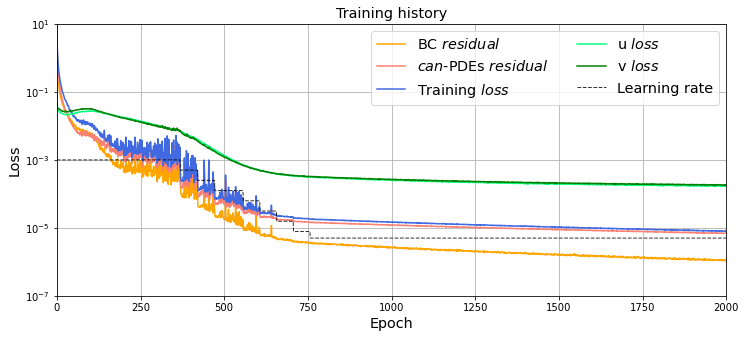

In [20]:
# plot loss history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
fig, axes = plt.subplots(1, figsize=(12, 5))
plt.plot(hist['epoch'], hist['bc_loss'], label=r'BC $residual$', alpha=1, c='orange');
plt.plot(hist['epoch'], hist['pde_loss'], label=r'$%s$-PDEs $residual$'%(scheme.split('-')[0]), alpha=1, c='salmon');
plt.plot(hist['epoch'], hist['loss'], label=r'Training $loss$', alpha=1, c='royalblue'); plt.yscale('log'); plt.grid();
plt.plot(hist['epoch'], hist['u_loss'], label=r'u $loss$', alpha=1, c='springgreen');
plt.plot(hist['epoch'], hist['v_loss'], label=r'v $loss$', alpha=1, c='green');
plt.plot(hist['epoch'], hist['lr'], "k--", label=r'Learning rate', alpha=.8, linewidth=1);
plt.xlabel('Epoch', size='x-large'); plt.ylabel('Loss', size='x-large'); plt.xlim((0, EPOCH)); plt.ylim((1e-7, 1e1));
plt.title(r'Training history', fontsize="x-large"); plt.legend(fontsize='x-large', ncol=2);

mse u  = 1.792e-04
mse v  = 1.931e-04
mse p  = 2.250e-02


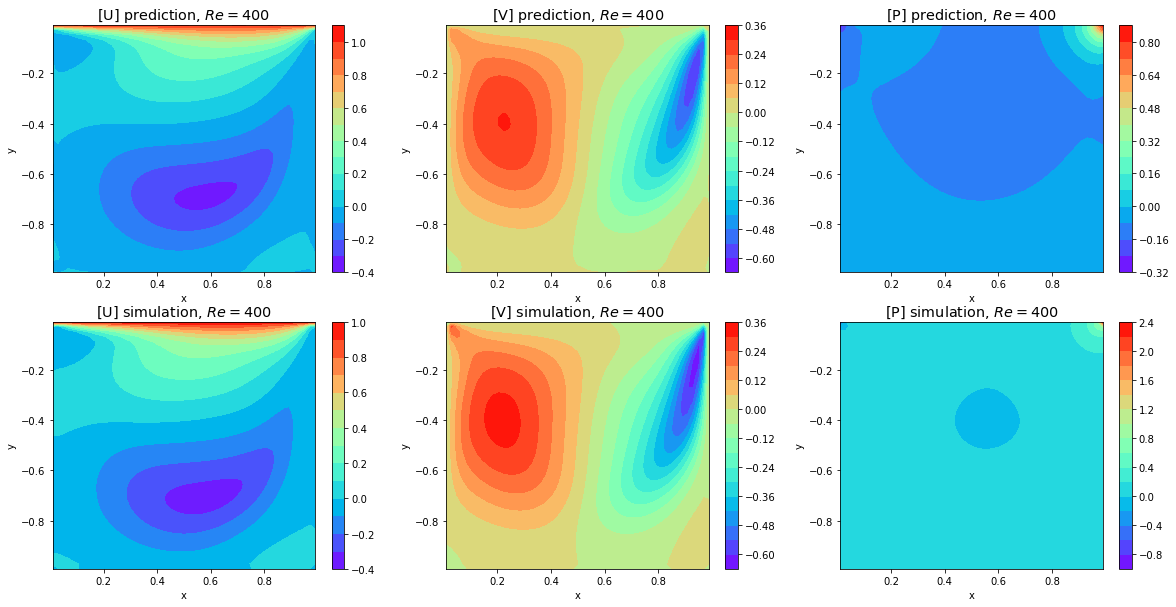

In [17]:
# new prediction & error on [train] data
p_u, p_v, p_p, _, _ = eval_ins(X_train)

# mse
mse_u =  np.mean((p_u.flatten() - y_train[:, 0].flatten())**2)
mse_v =  np.mean((p_v.flatten() - y_train[:, 1].flatten())**2)
mse_p =  np.mean((p_p.flatten() - y_train[:, 2].flatten())**2)
print ('mse u  = %.3e' %mse_u)
print ('mse v  = %.3e' %mse_v)
print ('mse p  = %.3e' %mse_p)

# visualize flow prediction
fig = plt.figure(figsize=(20, 10))

con_lv = 15
n = 51
_pu, _pv, _pp = p_u.reshape(n, n), p_v.reshape(n, n), p_p.reshape(n, n)
_u, _v, _p = y_train[:, 0].reshape(n, n), y_train[:, 1].reshape(n, n), y_train[:, 2].reshape(n, n)

# prediction
ax1 = fig.add_subplot(2,3,1)
plt.contourf(_pu, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[U] prediction, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,2)
plt.contourf(_pv, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[V] prediction, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,3)
plt.contourf(_pp, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[P] prediction, $Re=$%d' %Re, size='x-large');

# simulation
ax1 = fig.add_subplot(2,3,4)
plt.contourf(_u, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[U] simulation, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,5)
plt.contourf(_v, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[V] simulation, $Re=$%d' %Re, size='x-large');
ax1 = fig.add_subplot(2,3,6)
plt.contourf(_p, con_lv, origin='lower', cmap='rainbow', extent=ext, aspect='auto');
plt.colorbar(); plt.xlabel('x'); plt.ylabel('y'); plt.title(r'[P] simulation, $Re=$%d' %Re, size='x-large');   